In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark

In [2]:
resolution = 1000  #grid resolution in meters

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-26 01:34:05.415831] Starting...


In [4]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName("ProcessLidar").setMaster("spark://ip-10-0-4-160.ec2.internal:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-26 01:34:05.423520] Creating spark context


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/26 01:34:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-26 01:34:09.236249] Path:  ./datasets/		FullPath:/home/ec2-user/notebooks/NewOrleansElevation/datasets/


In [6]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}laz{os.sep}{testLasFileName}")

[2025-03-26 01:34:09.243805] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0801n3325.laz to get crs and more


In [7]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

<Axes: >

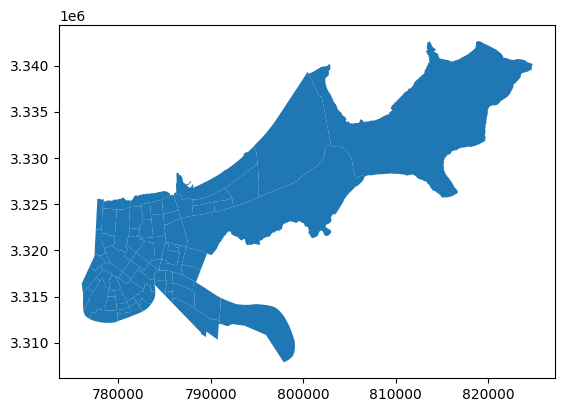

In [8]:
neighborhoodDf.plot()

In [9]:
bounds = [int(b) for b in neighborhoodDf.total_bounds]

In [10]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-26 01:34:10.688445] Resolution will be 48.807 x 34.758  Runtime based on 1696.4337060000003


In [11]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf.union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()


<Axes: >

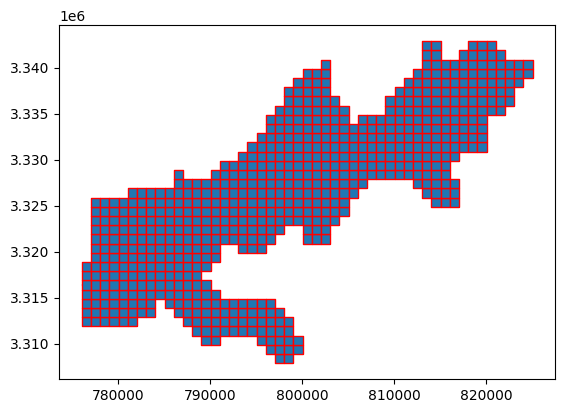

In [12]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [13]:
tileIndex = gpd.read_file(f"{dataPath}USGS_LA_2021GNO_1_C22_TileIndex{os.sep}USGS_LA_2021GNO_1_C22_TileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['Name'].map(lambda f: f"{fullDataPath}laz{os.sep}USGS_LPC_LA_2021GreaterNewOrleans_C22_{f}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex)
tileIndexBroadcast.value.head()

,Name,Comment,PRJ_ID,WU_ID,WU_Name,geometry
Name,,,,,,
/home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz,w0809n3329,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((810000 3329000, 809000 3329000, 8090..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0755n3296.laz,w0755n3296,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((756000 3296000, 755000 3296000, 7550..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0673n3303.laz,w0673n3303,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((674000 3303000, 673500 3303000, 6735..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0704n3295.laz,w0704n3295,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((705000 3295000, 704000 3295000, 7040..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0748n3320.laz,w0748n3320,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((749000 3320000, 748000 3320000, 7480..."


In [14]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')


def processLas(inputTup):
    startTime = datetime.now()
    
    BoxIdx = inputTup[0]
    boxBounds = inputTup[1:]
    
    lp(f"Processing for box[{BoxIdx}] {boxBounds}")

    altTotal = 0
    waterTotal = 0
    pointTotal = 0
    for idx, row in tileIndexBroadcast.value.iterrows():
        if not row['geometry'].intersects(shapely.box(*boxBounds)):
            #no intersection scip
            continue

        try:        
            las = laspy.read(idx)
        except FileNotFoundError:
            lp(f"path {idx} does not exist skipping" )
            continue
        
        
        central_meridian = int(meridianReg.findall(las.header.vlrs[0].string)[0]) * -1
    
        
        X = las.X
        Y = las.Y
        Z = las.Z
        cls = las.classification
    
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (boxBounds[0]*1000), (X <= (boxBounds[2]*1000)))
        inBoundsMaskY = np.logical_and(Y >= (boxBounds[1]*1000), (Y <= (boxBounds[3]*1000)))
        goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
        
        x = X[goodPointMask]/1000.0 #- bounds[0]
        y = (Y[goodPointMask]/1000.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        pointTotal += np.count_nonzero(goodPointMask)

    return (BoxIdx,altTotal, waterTotal, pointTotal, datetime.now() - startTime)


In [15]:
#Just for sanity
testIdx = 7
processLas(list(boxesDf.bounds.itertuples())[testIdx])

[2025-03-26 01:34:11.822700] Processing for box[39] (777039.0, 3311888.0, 778039.0, 3312888.0)
[2025-03-26 01:34:13.896076] path /home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0778n3311.laz does not exist skipping
[2025-03-26 01:34:14.027714] path /home/ec2-user/notebooks/NewOrleansElevation/datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0777n3311.laz does not exist skipping


(39,
 5714961075,
 2486,
 1102696,
 datetime.timedelta(seconds=2, microseconds=229546))

In [16]:
boxesRdd = sc.parallelize(boxesDf.bounds.itertuples(), 300)

In [17]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [18]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-26 01:34:14.435552] 648 boxes total


In [19]:
output = boxesProcessedRdd.collect()

In [20]:
boxesDf.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'Total', 'RunTime'], dtype='object')

In [21]:
output[0]

(4,
 3627875540,
 920,
 1696491,
 datetime.timedelta(seconds=14, microseconds=516934))

In [22]:
for out in output:
    boxesDf.loc[out[0], 'AltitudeTotal'] = out[1]
    boxesDf.loc[out[0], 'WaterTotal'] = out[2]
    boxesDf.loc[out[0], 'Total'] = out[3]
    boxesDf.loc[out[0], 'RunTime'] = out[4]

In [30]:
lp(f"{boxesDf['RunTime'].mean()} avg runtime\t\ttotal:  {boxesDf['RunTime'].sum()}")

[2025-03-26 01:37:16.707331] 0 days 00:00:23.752142 avg runtime		total:  0 days 04:16:31.388577


In [24]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,Total,RunTime
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",3.627876e+09,920.0,1696491.0,0 days 00:00:14.516934
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",1.047907e+10,2023.0,3068688.0,0 days 00:00:25.391670
6,"POLYGON ((777039 3313888, 777039 3314888, 7760...",1.115128e+10,8674.0,2667244.0,0 days 00:00:34.859661
7,"POLYGON ((777039 3314888, 777039 3315888, 7760...",7.757612e+09,9218.0,2502247.0,0 days 00:00:38.096958
8,"POLYGON ((777039 3315888, 777039 3316888, 7760...",7.398625e+09,3728.0,2895678.0,0 days 00:00:37.147325


In [25]:
outPath = f"{os.curdir}{os.sep}output{os.sep}"
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [26]:
boxesDf.to_pickle(f"{outPath}AggregateLidarData_{resolution}m.pickle")

In [27]:
with open(f"{outPath}FinishTime_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

<Axes: >

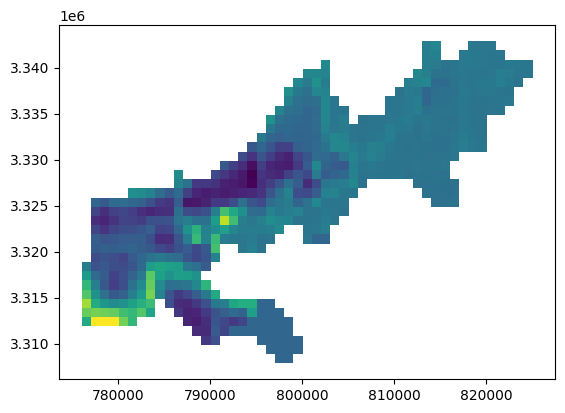

In [28]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total']
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
boxesDf.plot(column='AltCalc')

In [29]:
lp("Done!")

[2025-03-26 01:37:16.696473] Done!
